In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from itertools import cycle
#from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
plt.style.use('ggplot')   

from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
#tprs = []
#aucs = []
#base_fpr = np.linspace(0, 1, 101)






def test_model(modelo: GIN_classifier_to_explain_v2, loader: DataLoader, device: str = 'cpu'):
    
    modelo.eval()
    all_predictions = []
    all_true        = []
    tprs            = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    #correct = 0
    for i, val_data in enumerate(loader):
        
        assert not val_data.is_cuda
        if (device == 'cuda:0') | (device == 'cuda'):
            val_data.to(device, non_blocking=True) 
            assert val_data.is_cuda                          

        val_predictions = modelo(val_data.x, val_data.edge_index,  val_data.batch)# Make predictions for this batch
        pred            = val_predictions.argmax(dim=1)
        
        fpr, tpr, _ = roc_curve(pred.cpu().tolist(),  val_data.y.cpu().tolist())
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        
        
        #all_predictions.extend(pred.cpu().tolist())
        #all_true.extend(val_data.y.cpu().tolist())

    return tprs #all_predictions, all_true    #correct += int((pred == val_data.y).sum())
        


def get_plot_data(tprs):
    base_fpr = np.linspace(0, 1, 101)
    aucs = []
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    return base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc




def get_plot_params(model, loader_validation):
    

    model.eval()

    tprs = test_model(model, loader_validation, device = 'cuda:0')



    return get_plot_data(tprs)


#colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']

#loader_path = "./results/dataloaders/loader_Concen_plus_Fluxes.pt"



#model       = torch.load(
#                   "./results/trained_models/Non_masked_Phe/Model_GIN_classifier_to_explain_v2_06-11-2022_19h_05min_best_ValAcc_0.9894379479441721_epoch_9.pt")

model_Masked_Phe            = torch.load(
                                    "./results/trained_models/Masked_Phe/Model_GIN_classifier_to_explain_v2_06-11-2022_19h_12min_best_ValAcc_0.9200301772915881_epoch_83.pt")

loader_validation_Masked_Phe = torch.load("./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt").get_validation_loader()



base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc = get_plot_params(model_Masked_Phe.to(device, non_blocking=True), loader_validation_Masked_Phe)



model_NON_Masked_Phe            = torch.load(
                                    "./results/trained_models/Non_masked_Phe/Model_GIN_classifier_to_explain_v2_06-11-2022_19h_05min_best_ValAcc_0.9894379479441721_epoch_9.pt")

loader_validation_NON_Masked_Phe = torch.load("./results/dataloaders/loader_Concen_plus_Fluxes.pt").get_validation_loader()


base_fpr_2, mean_tprs_2, tprs_lower_2, tprs_upper_2, mean_auc_2, std_auc_2 = get_plot_params(model_NON_Masked_Phe.to(device, non_blocking=True), loader_validation_NON_Masked_Phe)




/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


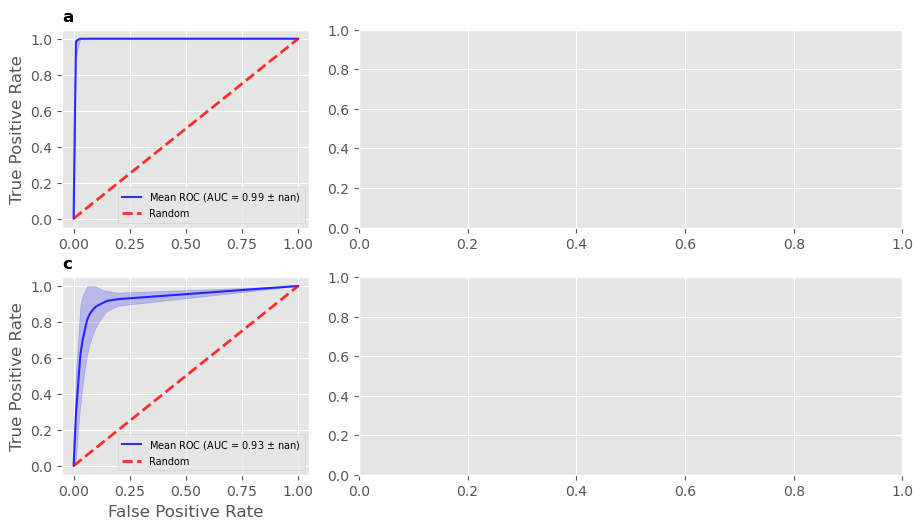

In [2]:

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=3)
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=1)
ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=.8, top=0.99, wspace=0.2, hspace=0.25)



def put_in_subplot(base_fpr, mean_tprs, tprs_lower,
                   tprs_upper, mean_auc, std_auc, AX, xlabel:str='', letter:str=''):
    
    AX.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    AX.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
    AX.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Random', alpha= 0.8)

    #ax1.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])

    AX.legend(loc="lower right", fontsize=7)
    AX.set_ylabel('True Positive Rate')
    AX.set_xlabel(xlabel)
    AX.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')


put_in_subplot(base_fpr_2, mean_tprs_2, tprs_lower_2, tprs_upper_2, mean_auc_2, std_auc_2 , ax1, letter = 'a')

put_in_subplot(base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc, ax3, xlabel = 'False Positive Rate', letter = 'c')



